In [157]:

import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter


In [158]:
# Load the JSON data
with open('data/processed/deputees_17.json', 'r', encoding='utf-8') as f:
    deputies = json.load(f)

with open('data/processed/vote_17.json', 'r', encoding='utf-8') as f:
    votes = json.load(f)

print(f"Loaded {len(deputies)} deputies")
print(f"Loaded {len(votes)} votes")

Loaded 611 deputies
Loaded 3404 votes


In [159]:
G = nx.Graph()

for deputy_id, deputy_info in deputies.items():
    G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))

print(f"Added {G.number_of_nodes()} nodes")

Added 611 nodes


In [160]:
# Track co-votes and total votes for each deputy pair
co_votes = {}  # Number of times both voted POUR together
deputy_votes = {}  # Track which votes each deputy participated in
total_voters = set()
# First pass: track which votes each deputy participated in
for vote_id, vote_data in votes.items():
    pour_voters = vote_data['votes_for']
    contre_voters = vote_data['votes_against']
    abstention_voters = vote_data['votes_abs']
    
    # All deputies who participated in this vote
    all_voters = set(pour_voters + contre_voters + abstention_voters)
    total_voters.update(pour_voters + contre_voters + abstention_voters)

    
    for deputy in all_voters:
        if deputy not in deputy_votes:
            deputy_votes[deputy] = set()
        deputy_votes[deputy].add(vote_id)
    
    # Track co-votes for POUR
    for i in range(len(pour_voters)):
        for j in range(i + 1, len(pour_voters)):
            deputy1 = pour_voters[i]
            deputy2 = pour_voters[j]
            
            if G.has_node(deputy1) and G.has_node(deputy2):
                pair = tuple(sorted([deputy1, deputy2]))
                co_votes[pair] = co_votes.get(pair, 0) + 0.5 



In [161]:
G = nx.Graph()

for deputy_id, deputy_info in deputies.items():
    G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))
    
# Second pass: create edges based on threshold
edges_added = 0
for (deputy1, deputy2), pour_count in co_votes.items():
    # Find common votes (votes both deputies participated in)
    common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
    total_common = len(common_votes)
    
    if total_common > 0:
        percentage = pour_count / total_common
    else:
        percentage = 0
    
    
            
    G.add_edge(deputy1, deputy2, weight=percentage)
        

print(f"Graph created with {G.number_of_nodes()} nodes")


Graph created with 611 nodes


In [162]:
# Basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Check if graph is connected
if nx.is_connected(G):
    print("Graph is connected")
else:
    print(f"Graph has {nx.number_connected_components(G)} connected components")

Number of nodes: 611
Number of edges: 179915
Average degree: 588.92
Graph has 9 connected components


603 nodes in the giant connected component
[0.07194244604316546, 0.06935123042505593, 0.06626506024096386, 0.18421052631578946, 0.06231454005934718, 0.10330578512396695, 0.08875739644970414, 0.07390300230946882, 0.09351145038167939, 0.09210526315789473, 0.08241758241758242, 0.11946902654867257, 0.06313993174061433, 0.060546875, 0.07250755287009064, 0.07093821510297482, 0.07984790874524715, 0.06643356643356643, 0.06446540880503145, 0.09615384615384616]


C:\Users\tchir\AppData\Local\Temp\ipykernel_36044\722495558.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


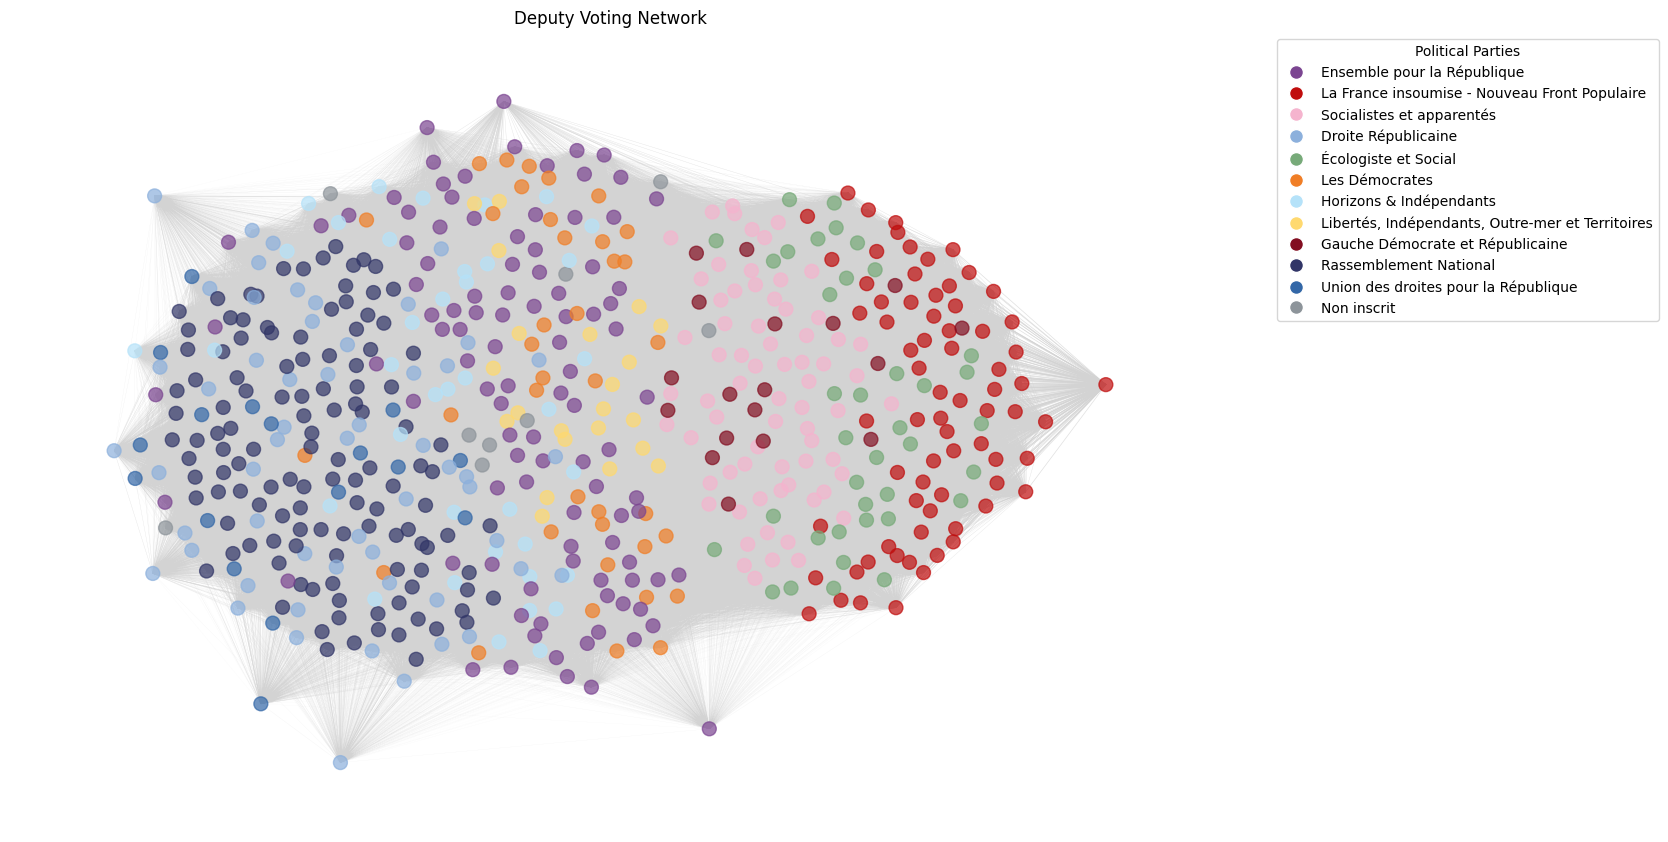

In [163]:

gcc_nodes = max(nx.connected_components(G), key=len)
GCC = G.subgraph(gcc_nodes).copy()

print(len(gcc_nodes), "nodes in the giant connected component")

nodes_color = [deputies[node].get('organ',{}).get('color','#cccccc') for node in GCC.nodes()]

party_colors = {deputies[node].get('organ',{}).get('color','#cccccc'):deputies[node].get('organ',{}).get('name','No name') for node in GCC.nodes()}



sample_nodes = list(GCC.nodes())
G_sample = GCC.subgraph(sample_nodes)

edge_weights = [G_sample[u][v]['weight'] for u, v in G_sample.edges()]
print(edge_weights[:20])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sample, k=500, iterations=50, weight='weight', seed=42)
nx.draw(G_sample, 
        pos, 
        node_size=100, node_color=nodes_color, 
        edge_color='lightgray',
        alpha=0.7, with_labels=False, width=edge_weights)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=name,
              markerfacecolor=color, markersize=10) for color, name in party_colors.items()],
           title="Political Parties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Deputy Voting Network")
plt.tight_layout()
plt.show()

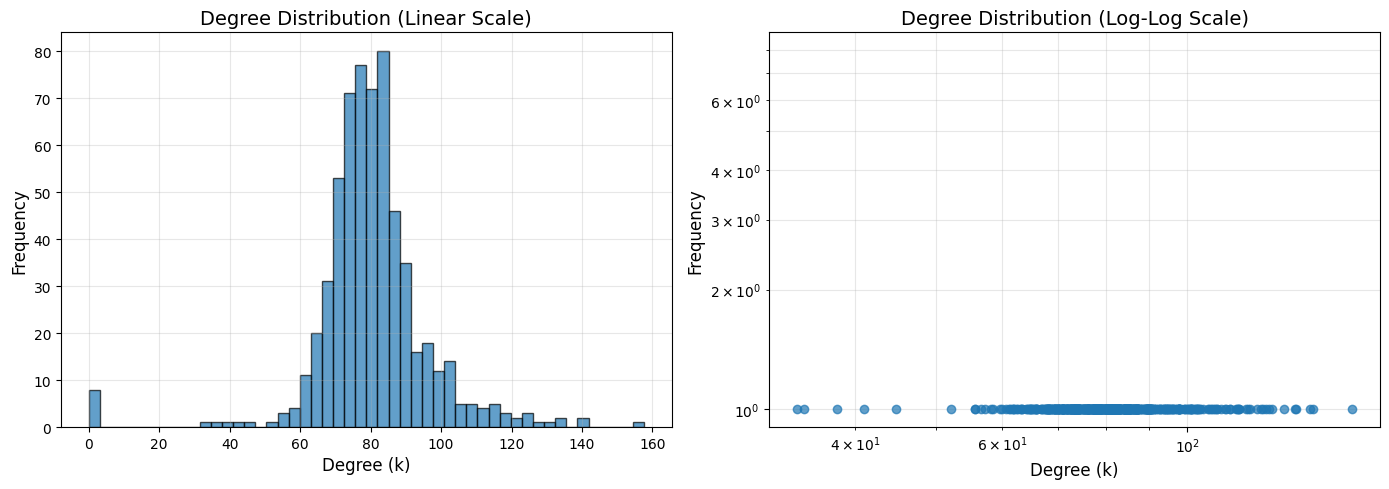

Mean degree: 80.46
Median degree: 79.91
Mode degree: 0
Min degree: 0
Max degree: 157.6247208381337
Standard deviation: 16.46


In [164]:
# Degree distribution
degrees = dict(G.degree(weight='weight'))
degree_values = list(degrees.values())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Degree (k)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Degree Distribution (Linear Scale)', fontsize=14)
axes[0].grid(alpha=0.3)

# Log-log scale for power-law detection
degree_counts = Counter(degree_values)
ks = sorted(degree_counts.keys())
counts = [degree_counts[k] for k in ks]

axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
axes[1].set_xlabel('Degree (k)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Degree Distribution (Log-Log Scale)', fontsize=14)
axes[1].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Statistical summary
print(f"Mean degree: {np.mean(degree_values):.2f}")
print(f"Median degree: {np.median(degree_values):.2f}")
print(f"Mode degree: {max(set(degree_values), key=degree_values.count)}")
print(f"Min degree: {min(degree_values)}")
print(f"Max degree: {max(degree_values)}")
print(f"Standard deviation: {np.std(degree_values):.2f}")

## Communities

C:\Users\tchir\AppData\Local\Temp\ipykernel_36044\1405644094.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_36044\1405644094.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


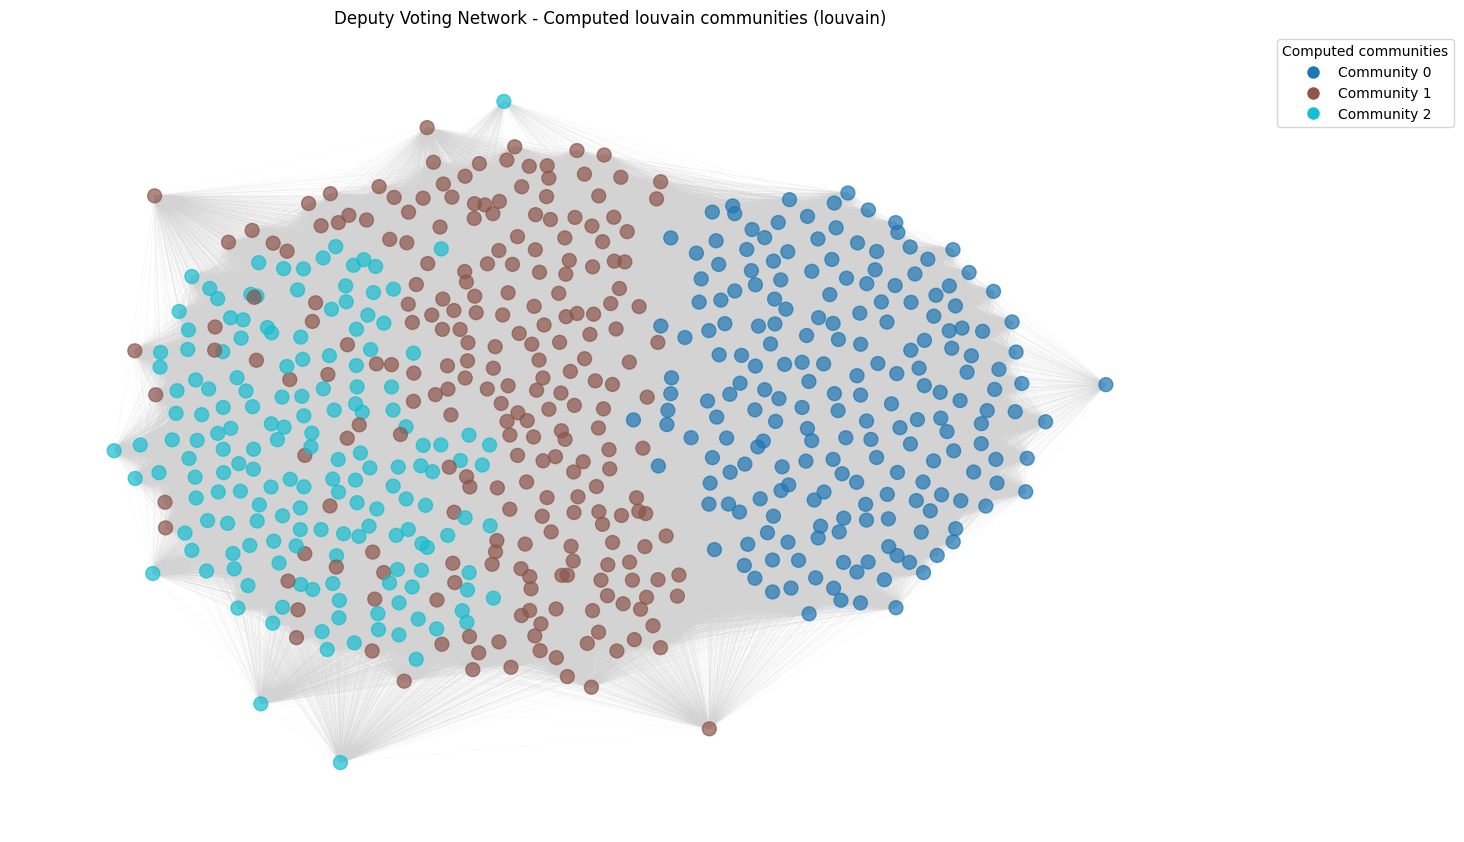

Number of communies : 3
Modularity score : 0.19481310466614302
C0 : Naillet Philippe , Socialistes et apparentés
C1 : Darmanin Gérald , Ensemble pour la République
C2 : Giletti Frank , Rassemblement National


In [181]:
communities_set = nx.community.louvain_communities(G_sample, weight="weight")
num_communities = len(communities_set)

partition = {}
for community_id, nodes in enumerate(communities_set):
    for node in nodes:
        partition[node] = community_id

cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)

# --- This is the list for node_color ---
nodes_color_com = [cmap(partition[node]) for node in G_sample.nodes()]

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i}', markerfacecolor=cmap(i), markersize=10) for i in range(num_communities)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sample, k=500, iterations=50, weight= 'weight', seed=42)
nx.draw(G_sample, 
        pos, 
        node_size=100, node_color=nodes_color_com, 
        edge_color='lightgray',
        alpha=0.7, with_labels=False, width=0.1)
plt.legend(handles=legend_handles,
           title="Computed communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Deputy Voting Network - Computed louvain communities (louvain)")
plt.tight_layout()
plt.show()

print(f'Number of communies : {len(communities_set)}')
modularity_score = nx.community.modularity(G_sample, communities_set, weight='weight')
print(f"Modularity score : {modularity_score}")

for i, community in enumerate(communities_set):
      r_idx = random.randint(0, len(list(community)))
      print(f"C{i} : {deputies[list(community)[r_idx]].get('name')} , {deputies[list(community)[r_idx]]['organ']['name']}")

In [166]:
#communities_list = [list(community) for community in communities_set]
#with open('data/processed/communautes.json', 'w', encoding='utf-8') as f:
#    json.dump(communities_list, f, indent=4)


In [167]:
organ_name_dict = {}
for dep in list(deputies.keys()):
    organ_id = deputies[dep]['organ']['id']
    organ_name = deputies[dep]['organ']['name']
    organ_short_name = deputies[dep]['organ']['name_short']
    if organ_id not in organ_name_dict:

        organ_name_dict[organ_id] = (organ_name, organ_short_name)

In [168]:
communities_dict = {}
for i,comm in enumerate(list(communities_set)):
    communities_dict[f"C{i}"] = comm

print(list(communities_dict.values()))

[{'PA720952', 'PA842263', 'PA793174', 'PA795982', 'PA791824', 'PA795164', 'PA841813', 'PA793948', 'PA841107', 'PA841251', 'PA794906', 'PA720992', 'PA793912', 'PA608172', 'PA736201', 'PA794870', 'PA795672', 'PA841091', 'PA607553', 'PA793708', 'PA841665', 'PA842013', 'PA2940', 'PA791812', 'PA1567', 'PA842187', 'PA841515', 'PA840903', 'PA643175', 'PA795482', 'PA794854', 'PA842155', 'PA841717', 'PA795746', 'PA841367', 'PA840665', 'PA842211', 'PA840673', 'PA841315', 'PA794130', 'PA610654', 'PA795430', 'PA720362', 'PA842105', 'PA721210', 'PA841223', 'PA340343', 'PA342384', 'PA794270', 'PA719286', 'PA795136', 'PA796010', 'PA817211', 'PA642764', 'PA342196', 'PA795820', 'PA794938', 'PA795108', 'PA793816', 'PA794710', 'PA841701', 'PA841539', 'PA841327', 'PA794778', 'PA606793', 'PA794138', 'PA795240', 'PA722150', 'PA722142', 'PA793772', 'PA841243', 'PA794154', 'PA793624', 'PA335612', 'PA841471', 'PA795454', 'PA793756', 'PA643192', 'PA842045', 'PA796106', 'PA841681', 'PA795362', 'PA794082', 'PA795

In [169]:
partis_members = {}
    
for id_member, data_member in deputies.items():
    # Récupère l'ID du parti
    id_parti = data_member['organ']['id']
    if id_parti in partis_members:
        partis_members[id_parti].append(id_member)
    else:
        partis_members[id_parti] = [id_member]

print(partis_members)

{'PO845407': ['PA795050', 'PA795958', 'PA795144', 'PA759832', 'PA718674', 'PA719372', 'PA795990', 'PA795884', 'PA721024', 'PA721908', 'PA722382', 'PA2960', 'PA720446', 'PA795950', 'PA335758', 'PA719798', 'PA795864', 'PA721158', 'PA719472', 'PA795386', 'PA720154', 'PA721916', 'PA794802', 'PA643184', 'PA642935', 'PA795664', 'PA720022', 'PA345722', 'PA719388', 'PA721852', 'PA722190', 'PA795920', 'PA720342', 'PA721750', 'PA721296', 'PA841709', 'PA795962', 'PA794798', 'PA267200', 'PA719338', 'PA842147', 'PA721134', 'PA817203', 'PA721426', 'PA720066', 'PA795528', 'PA719756', 'PA719632', 'PA721004', 'PA719890', 'PA842311', 'PA840235', 'PA722366', 'PA721764', 'PA719550', 'PA721584', 'PA607395', 'PA841927', 'PA720354', 'PA717379', 'PA795722', 'PA719404', 'PA793416', 'PA722102', 'PA720146', 'PA677483', 'PA793270', 'PA642695', 'PA606507', 'PA712014', 'PA720370', 'PA794330', 'PA719922', 'PA795908', 'PA794982', 'PA721170', 'PA841601', 'PA719412', 'PA795730', 'PA794206', 'PA722000', 'PA793940', 'PA7

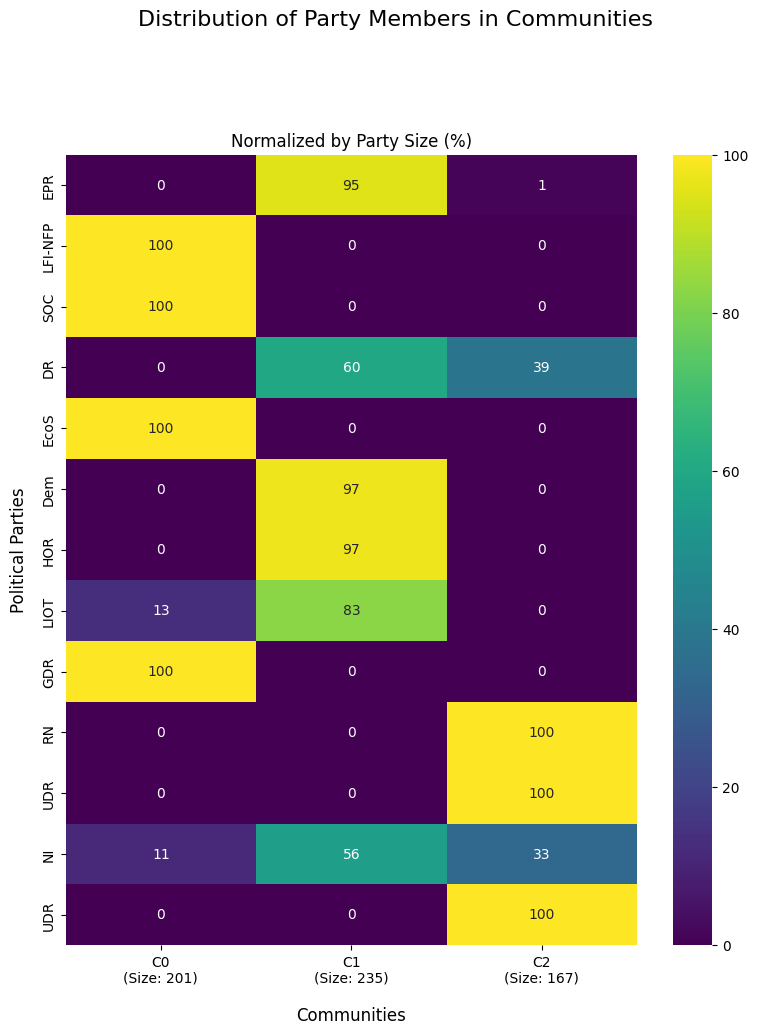

Community Key:
C0 : (Size: 201)
C1 : (Size: 235)
C2 : (Size: 167)


In [170]:
def calculate_matrix_D(dict_partis, dict_commu_raw, all_member_ids, norm_vertical=False, norm_horizontal=True, plot=True):

    # Convert the raw frozenset dictionary into the (name, [members]) tuple format
    community_tuples = [] # This will be [(comm_key, [members]), ...]
    
    # Sort by key (C0, C1, ...) to ensure consistent order
    sorted_comm_keys = sorted(dict_commu_raw.keys()) 
    
    for comm_key in sorted_comm_keys:
        comm_set = dict_commu_raw[comm_key]
        members_in_comm = []
        
        # Only extract member IDs
        for item in comm_set:
            if item in all_member_ids:
                members_in_comm.append(item)
                
        # Store the KEY (C0, C1...) as the "name"
        community_tuples.append((comm_key, members_in_comm))
    
    
   
    party_member_lists = list(dict_partis.values())
    
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(0, num_parti):  # Iterate over parties (rows)
        party_i_members = party_member_lists[i]
        
        for j in range(0, num_commu): # Iterate over communities (columns)
            community_j_tuple = community_tuples[j]
            community_j_members = community_j_tuple[1] # Get the member list (index 1)
            
            # Find members from community j that are also in party i
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            

            if norm_vertical:
                num_community_members = len(community_j_members)
                if num_community_members > 0: 
                    D[i, j] *= 100 / num_community_members
                else:
                    D[i, j] = 0 
            
            elif norm_horizontal:
                num_party_members = len(party_i_members)
                if num_party_members > 0: # Évite la division par zéro
                    D[i, j] *= 100 / num_party_members
                else:
                    D[i, j] = 0 # Parti vide
            

    if plot:
        # Axes X (Columns) and Y (Lines) : Communitie and genre names
        
        x_labels = [f"{community_tuple[0]}\n(Size: {len(community_tuple[1])})" for j, community_tuple in enumerate(community_tuples)]
        
        y_labels = [organ_name_dict[g][1] for g in list(dict_partis.keys())]
        
        fig_width = max(8, num_commu * 2.5) 
        fig_height = max(6, num_parti * 0.8)
        
        plt.figure(figsize=(fig_width, fig_height)) 
        
        sns.heatmap(
            D,
            annot=True,          # Show the numbers in each bloc
            fmt='.0f',           # Format as int
            cmap='viridis',      # Color (Blue=Weak, Yellow=Strong)
            xticklabels=x_labels,
            yticklabels=y_labels
        )
        plt.suptitle('Distribution of Party Members in Communities', fontsize=16, y=1.02)
        if norm_vertical:
            plt.title(f'Normalized by Community Size (%)')
        elif norm_horizontal:
            plt.title(f'Normalized by Party Size (%)')
        else:
            plt.title(f'Absolute Count of Members')
            
        plt.xlabel('Communities', fontsize=12, labelpad=15)
        plt.ylabel('Political Parties', fontsize=12, labelpad=10)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
        plt.show()
        
        print("Community Key:")
        for i, community_tuple in enumerate(community_tuples):
            print(f'{community_tuple[0]} : (Size: {len(community_tuple[1])})')
            
    return D

matrix_D = calculate_matrix_D(
    partis_members,       
    communities_dict, 
    plot=True,
    norm_vertical=False,
    norm_horizontal= True,
    all_member_ids = set(deputies.keys())
)

## Organ macro graph

In [ ]:
list_partis = list(partis_members.keys())
print('len', len(list_partis))
proximites_partis = {}
exist = 0
noexist = 0
for i in range(len(list_partis)-1):
    for j in range(i+1, len(list_partis)):
        proximites = []
        for member_i in partis_members[list_partis[i]]:
            for member_j in partis_members[list_partis[j]]:
                if member_j in total_voters and member_i in total_voters:
                    if G_sample.has_edge(member_i, member_j):
                        exist +=1
                        proximites.append(G_sample[member_i][member_j]['weight']) # works because fully connected
                    else:
                        noexist +=1
                        proximites.append(0)
        proximites_partis[(list_partis[i], list_partis[j])] = np.mean(proximites)
print('exist', exist)
print(noexist)
print(proximites_partis)

len 13
exist 158291
5628
{('PO845407', 'PO845413'): np.float64(0.05661225975947045), ('PO845407', 'PO845419'): np.float64(0.09606220079992812), ('PO845407', 'PO845425'): np.float64(0.14350577275091697), ('PO845407', 'PO845439'): np.float64(0.07438287591118428), ('PO845407', 'PO845454'): np.float64(0.1672011480140741), ('PO845407', 'PO845470'): np.float64(0.1725162547542314), ('PO845407', 'PO845485'): np.float64(0.17325869583505127), ('PO845407', 'PO845514'): np.float64(0.08850779504418181), ('PO845407', 'PO845401'): np.float64(0.1057389202544232), ('PO845407', 'PO872880'): np.float64(0.1129115124169756), ('PO845407', 'PO840056'): np.float64(0.15277324039399154), ('PO845407', 'PO847173'): np.float64(0.16580860432804187), ('PO845413', 'PO845419'): np.float64(0.21859217371295545), ('PO845413', 'PO845425'): np.float64(0.04256731167837343), ('PO845413', 'PO845439'): np.float64(0.24741290290018314), ('PO845413', 'PO845454'): np.float64(0.06274985752515705), ('PO845413', 'PO845470'): np.float

In [172]:
sorted_proximities = sorted(proximites_partis.items(), key= lambda x:x[1])
for (o1, o2), dis in sorted_proximities:
    print(f"{organ_name_dict[o1][1]} - {organ_name_dict[o2][1]} : {dis}")


LFI-NFP - DR : 0.04332744224405867
LFI-NFP - UDR : 0.04966293585673953
LFI-NFP - HOR : 0.05137485182490789
EcoS - UDR : 0.0523037693540704
LFI-NFP - UDR : 0.05787181942180391
EPR - LFI-NFP : 0.0588323483774889
LFI-NFP - RN : 0.06114178749064608
DR - EcoS : 0.0615865224810938
EcoS - RN : 0.06323750517358599
LFI-NFP - Dem : 0.06440116956529277
EcoS - UDR : 0.06958201803073226
SOC - UDR : 0.07013869076967583
EcoS - HOR : 0.07455804585348201
EPR - EcoS : 0.07729985143711307
SOC - RN : 0.079000535385997
LFI-NFP - NI : 0.0817786932513424
SOC - DR : 0.08304711888216164
DR - GDR : 0.0837252285146012
EcoS - Dem : 0.08621338620352641
GDR - UDR : 0.08734853269047516
EPR - GDR : 0.09197868896748308
HOR - GDR : 0.09300060719664748
SOC - HOR : 0.09873528099688783
GDR - RN : 0.09910821011327747
SOC - UDR : 0.09947363159993819
EPR - SOC : 0.09982934592933705
EcoS - NI : 0.10248685110573662
Dem - GDR : 0.10390546415270743
LFI-NFP - LIOT : 0.10683986405187514
Dem - RN : 0.10864870236863045
EPR - RN : 0.

In [173]:
G_partis = nx.Graph()

# --- PRÉPARATION DES LABELS ---
labels_dict = {} 

for parti_id, members in partis_members.items():
    # On récupère le nom lisible via ta formule
    # On ajoute un try/except au cas où un ID manquerait dans le dict
    try:
        nom_parti = organ_name_dict[parti_id][1]
    except KeyError:
        nom_parti = parti_id # Fallback sur l'ID si nom introuvable
        
    # On ajoute le noeud avec ses attributs
    count = len(members)
    G_partis.add_node(parti_id, count=count, label_name=nom_parti)
    
    # On remplit le dictionnaire pour l'affichage
    # Format : "Nom \n (Nombre)" pour un affichage sur 2 lignes
    labels_dict[parti_id] = f"{nom_parti}\n({count})"

# 2. Ajout des arêtes (Distance -> Poids)
for (p1, p2), dist in proximites_partis.items():
    safe_dist = dist if dist > 0.01 else 0.01
    weight_val = 1.0 / safe_dist
    G_partis.add_edge(p1, p2, distance=dist, weight=weight_val)



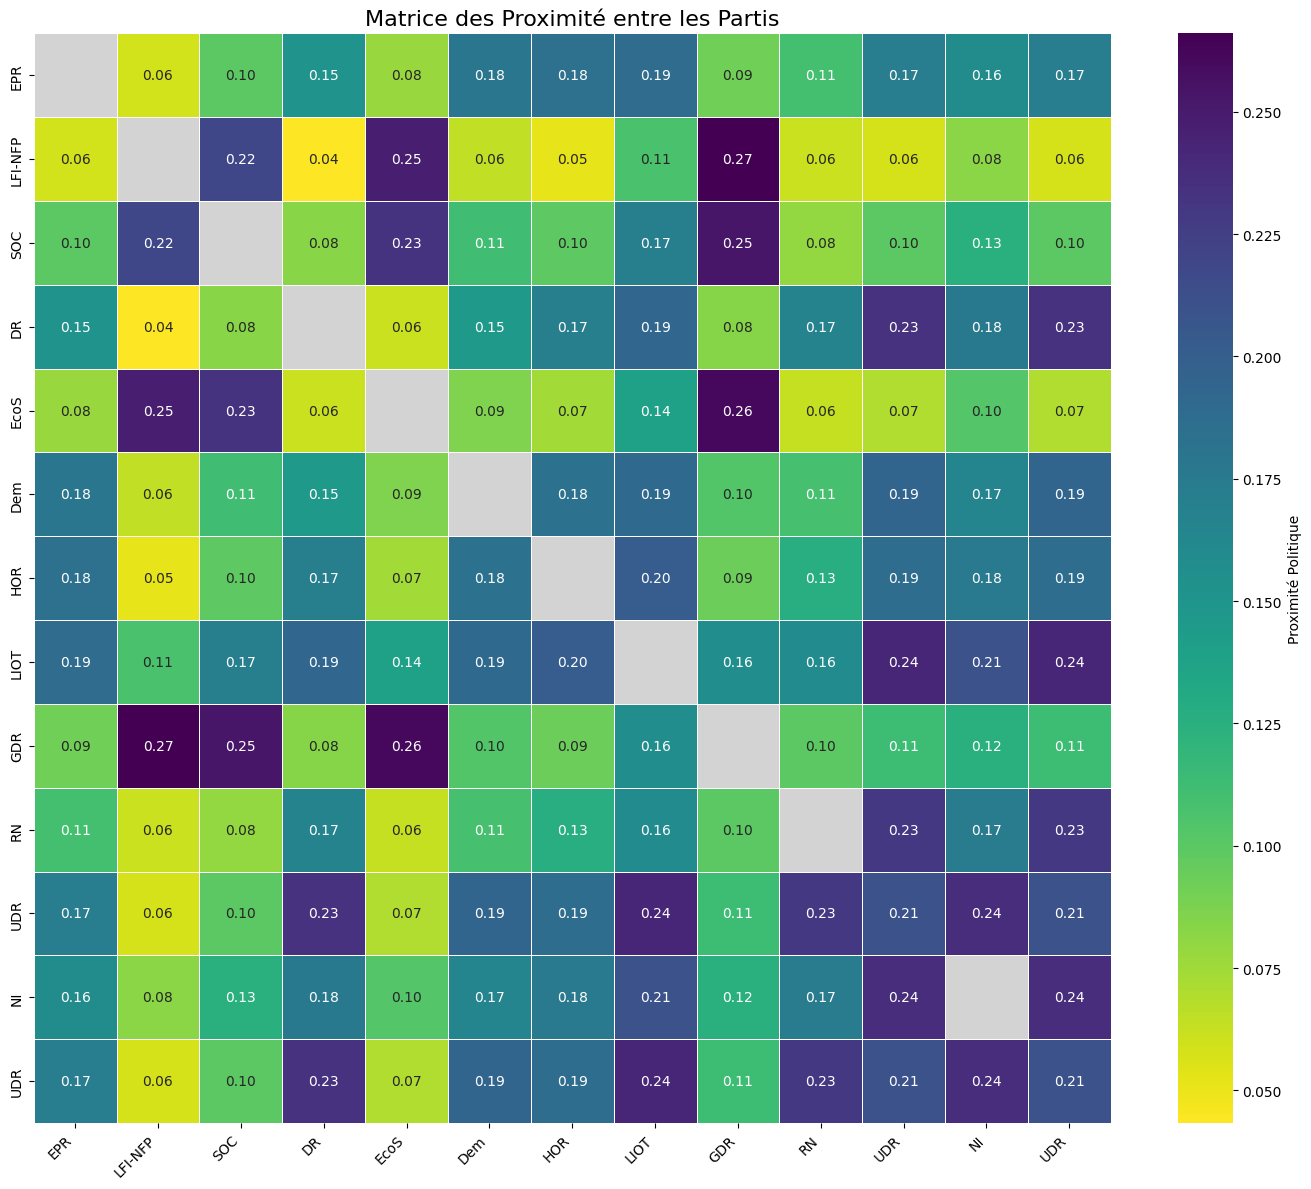

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ... (Votre code de récupération des IDs et noms reste identique) ...
parties_ids = list(G_partis.nodes())
parties_names = [G_partis.nodes[pid]['label_name'] for pid in parties_ids]
n = len(parties_ids)

# 2. Initialisation de la matrice
dist_matrix = pd.DataFrame(np.nan, index=parties_names, columns=parties_names)

# --- MODIFICATION CLEF ---
# On s'assure que la diagonale est bien NaN (et non 1).
# Cela empêche la diagonale d'écraser l'échelle de couleur.
np.fill_diagonal(dist_matrix.values, np.nan) 

# 3. Remplissage de la matrice (Reste identique)
for (p1, p2), dist in proximites_partis.items():
    if p1 in parties_ids and p2 in parties_ids:
        name1 = G_partis.nodes[p1]['label_name']
        name2 = G_partis.nodes[p2]['label_name']
        dist_matrix.loc[name1, name2] = dist
        dist_matrix.loc[name2, name1] = dist

# 4. Affichage de la Heatmap
plt.figure(figsize=(14, 12))

# On capture l'objet "axes" (ax) pour modifier le fond
ax = sns.heatmap(dist_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="viridis_r", 
            linewidths=0.5,
            cbar_kws={'label': 'Proximité Politique'})

# --- ETAPE DE GRISE ---
# On définit la couleur de fond du graphique. 
# Comme les NaN sont transparents, cette couleur apparaîtra à travers.
ax.set_facecolor('lightgray') 

plt.title("Matrice des Proximité entre les Partis", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Calcul de modularité avec les partis

In [ ]:
import networkx as nx

nodes_in_graph = set(G_sample.nodes())

cleaned_parti_com = []
seen_nodes = set()

for members in partis_members.values():
    # Only keep member in the graph
    valid_members = [m for m in members if m in nodes_in_graph]
    
    if valid_members:
        cleaned_parti_com.append(valid_members)
        seen_nodes.update(valid_members)

# 3. Gérer les nœuds oubliés (ceux dans le graphe mais pas dans partis_members)
missing_nodes = list(nodes_in_graph - seen_nodes)

modularity_score_parti = nx.community.modularity(G_sample, cleaned_parti_com, weight='weight')
print(f"Modularity score - partis : {modularity_score_parti}")

print(f"Modularity score - louvain communities : {modularity_score}")

Modularity score - partis : 0.0854304106607693
Modularity score - louvain communities : 0.19481310466614302
